## Objective
The objectives of this notebook are as follows:
- To showcase the effectiveness and stability of finetuning on a specific dataset
    - The chatbot model is finetuned to speak ethically, and the RL-based model improves the ethics score
    - Note that the finetuning process can be unstable and may require hyperparameter tuning
- To demonstrate various options and modifications of original algorithms in [1]-[3]:
    - Several modifications to the PPO implementation
    - Use of KL divergence instead of log probability ratio
## NLP Model and Dataset
We used a Korean chatbot dataset [4] and a dataset of Korean ethical (hate) speech [5]. 
Since training the model from scratch is difficult, we used koBART from [6], as a pretrained model. 
Using this pretrained model, we trained our own model to estimate the ethics of text (train_cls.py, model_cls.bin) and to generate casual conversation (`train_nlp.py`, `model_nlp.bin`).

In finetuning_nlg.py, the model is finetuned to generate ethical conversation. 
Note that instead of using the trained scoring function (`model_cls.bin`), human feedback can be used for finetuning. 
We used the trained scoreing function instead of human feedback for the sake of consistency, but the trained model may not have an accurate feedback which demands attention.

## References
[1] Ziegler, Daniel M., et al. "Fine-tuning language models from human preferences." arXiv preprint arXiv:1909.08593 (2019).

[2] Stiennon, Nisan, et al. "Learning to summarize with human feedback." Advances in Neural Information Processing Systems 33 (2020): 3008-3021.

[3] https://github.com/openai/lm-human-preferences

[4] https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100

[5] https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=558

[6] https://github.com/SKT-AI/KoBART

In [1]:
import argparse
import time
import os
import warnings
import gc

import numpy as np
import pandas as pd
import torch

from sklearn import metrics
from tqdm import tqdm

import matplotlib.pyplot as plt

/home/icsml2/anaconda3/envs/dsenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Baseline and Ethics Score

We score the ethicity of text using the trained model. As the score has variance, use use moving average. Furthermore, to estimate the ethics score improvement, we substitude the ethics score without finetuning. 
The score improvement is given as follows

## Effectiveness and stability of finetuning

We first compare score with/without finetuning

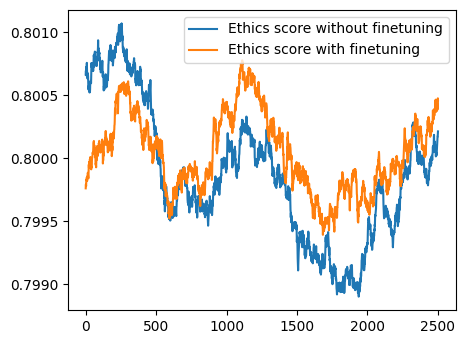

In [2]:
plt.figure(figsize=(5, 3.9))
N=500
yb  = 0.8+0.2*np.load('score_K_1_lr_0.npy')#/25+0.8
y_b = np.convolve(yb, np.ones(N)/N, mode='valid')
plt.plot(y_b, label=f'Ethics score without finetuning')

y  = 0.8+0.2*np.load('score_K_1_lr_1e-6.npy')#/25+0.8
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
plt.plot(y_, label=f'Ethics score with finetuning')
plt.legend()

### Plot the improvement

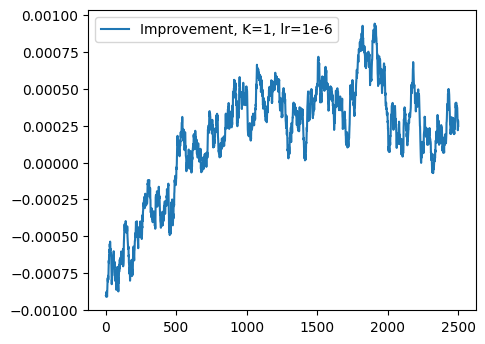

In [9]:
plt.figure(figsize=(5, 3.9))
N=500
yb  = 0.8+0.2*np.load('score_K_1_lr_0.npy')#/25+0.8
y  = 0.8+0.2*np.load('score_K_1_lr_1e-6.npy')#/25+0.8
y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
plt.plot(y_, label=f'Improvement, K=1, lr=1e-6')
plt.legend()
plt.savefig('fig_K1_lr_1e-6.png')

Note that the finetuning improves ethics of model.
We guess the score difference is not huge due to the following reasons:
 - model_cls designed to output the ethics of text with range 0~1, however, in this dataset, score of original text (and trained nlg text) has similar ethics score.
 - The model and dataset is not big enough to improve sufficiently.
 - Large target KL divergence
 - Or lack of intense hyperparameter tuning.
 
To improve the score further under given dataset and model, the learning rate, number of PPO step, or target KL divergnece can be changed, however, it seems the higher learning rate or number of PPO steps harms the stability. In case of KL diverenge, trade-offs (stability vs performance) exists 

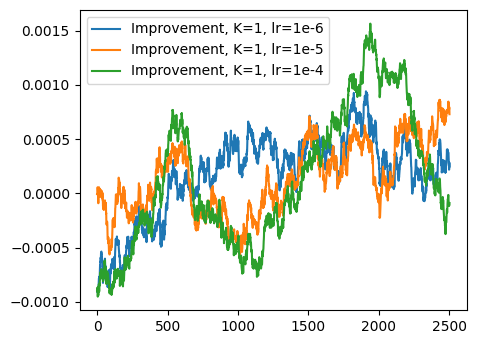

In [4]:
## Score improvement with different learning rate
plt.figure(figsize=(5, 3.9))
N=500
yb  = 0.8+0.2*np.load('score_K_1_lr_0.npy')#/25+0.8
y  = 0.8+0.2*np.load('score_K_1_lr_1e-6.npy')#/25+0.8
y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
plt.plot(y_, label=f'Improvement, K=1, lr=1e-6')
y  = 0.8+0.2*np.load('score_K_1_lr_1e-5.npy')#/25+0.8
y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
plt.plot(y_, label=f'Improvement, K=1, lr=1e-5')
y  = 0.8+0.2*np.load('score_K_1_lr_1e-4.npy')#/25+0.8
y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
plt.plot(y_, label=f'Improvement, K=1, lr=1e-4')
plt.legend()

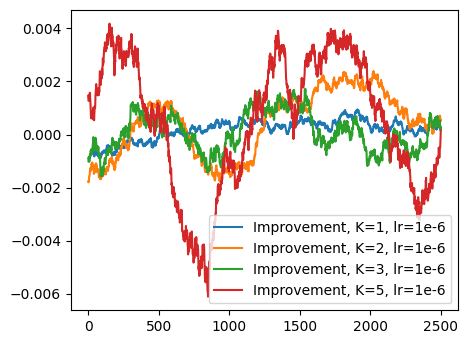

In [5]:
## Score improvement with different PPO steps
plt.figure(figsize=(5, 3.9))
N=500
yb  = 0.8+0.2*np.load('score_K_1_lr_0.npy')#/25+0.8
for k in [1, 2, 3, 5]:
    y  = 0.8+0.2*np.load(f'score_K_{k}_lr_1e-6.npy')#/25+0.8
    y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
    plt.plot(y_, label=f'Improvement, K={k}, lr=1e-6')
plt.legend()

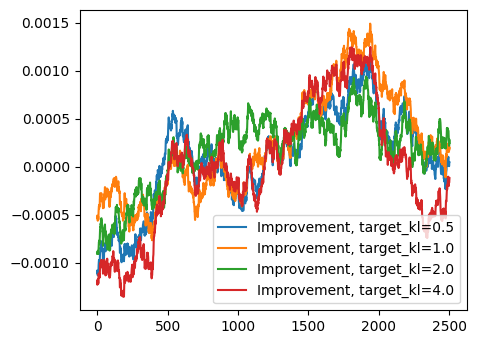

In [6]:
## Score improvement with different PPO steps
plt.figure(figsize=(5, 3.9))
N=500
yb  = 0.8+0.2*np.load('score_K_1_lr_0.npy')#/25+0.8
for k in [0.5, 1.0, 2.0, 4.0]:
    y  = 0.8+0.2*np.load(f'score_kl_{k}.npy')#/25+0.8
    y_ = np.convolve(y-yb, np.ones(N)/N, mode='valid')
    plt.plot(y_, label=f'Improvement, target_kl={k}')
plt.legend()

## KL Divergence Instead of Log Probability Ratio
To finetune the language model using the feedback, the reward $R(x_{k+1},x_k)$ is used.
In [1]-[2], the reward for the $t$-th token is given as
$$
R(x_t)=r(x_t)-\beta \log \frac{\pi(x_t|x_\text{prev})}{\rho(x_t|x_\text{prev})},
$$
where $\pi$ is current model and $\rho$ is previous or target model (in our experiment, $\rho$ is target model, soft updated with $\tau=1e-4$)
Here, $r(x_t)$ is score function encouraging the model to be better (the RL agent is trained to get higher $R(x_t)$, higher $r(x_t)$ means more suitable token.)
The log probabilty ratio prevents model to be updated too quickly (higher log ratio means rapid update, which should be avoided for the stability).

In [3], the log probability ratio is estimated using few tokens, e.g., $\sum_{k\in \text{topk}(\pi(x_{t,k}))}\log\frac{\pi(x_{t,k})}{\rho(x_{t,k})}$. 
In our project, we add 'kl_div' option that estimate the KL divergence instead of probability ratio of few tokens.

We first shows average value of $\beta \log \frac{\pi(x_t|x_\text{prev})}{\rho(x_t|x_\text{prev})}$. We use adaptive KL to makes the average value 2.

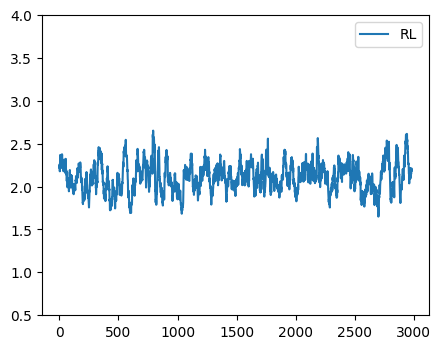

In [7]:
# Plot aver
plt.figure(figsize=(5, 3.9))
N=20
y  = np.load('training_beta.npy')#/25+0.8
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
plt.ylim([0.5, 4])
plt.plot(y_, label=f'RL')

plt.legend()
#plt.savefig('221006_curve')

Then we show the following parameters:
- KL divergence
- Average reward instead of per token reward
- Use of advtanage function

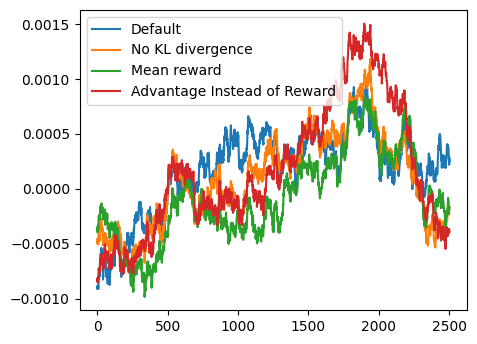

In [8]:
plt.figure(figsize=(5, 3.9))
N=500
y  = 0.8+0.2*np.load('score_K_1_lr_1e-6.npy')#/25+0.8
y = y-yb[:len(y)]
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
#plt.ylim([0, 10])
plt.plot(y_, label=f'Default')

y  = 0.8+0.2*np.load('score_kl_div_F.npy')#/25+0.8
y = y-yb[:len(y)]
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
#plt.ylim([0, 10])
plt.plot(y_, label=f'No KL divergence')

y  = 0.8+0.2*np.load('score_mean_reward_T.npy')#/25+0.8
y = y-yb[:len(y)]
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
#plt.ylim([0, 10])
plt.plot(y_, label=f'Mean reward')

y  = 0.8+0.2*np.load('score_R_as_adv_F.npy')#/25+0.8
y = y-yb[:len(y)]
y_ = np.convolve(y, np.ones(N)/N, mode='valid')
#plt.ylim([0, 10])
plt.plot(y_, label=f'Advantage Instead of Reward')

plt.legend()
#plt.savefig('221006_curve')

**No KL divergence** 
Note that the kl diverenge is better than sampled log probability ratios.

**Mean reward** 
Furthermore mean reward of whole text gives worse performance than reward estimation per token

**Reward Instead of Advantage** Actually, PPO algorithm requires advantage and the original paper also use advantage function, but it seems only in this setting the use of reward is better.